# EDA

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")

from IPython.display import display


plt.rcParams["figure.figsize"] = [8, 6]
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
plt.style.use('ggplot')


In [2]:
treino = pd.read_csv('../.data/train.csv',index_col='id')
teste = pd.read_csv('../.data/test.csv',index_col='id')

Xtrain = treino[['comment_text']]
ytrain = treino[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate']]

Xtest = teste[['comment_text']]
labels = ytrain.columns.to_list()

In [3]:
descript_stats = ytrain.describe()
descript_stats.loc['imbalance_ratio'] = ytrain.apply(pd.value_counts,axis=0) \
    .apply(lambda x: x[0]/x.sum()) 

for x in [teste.sample(5),descript_stats]:
    display(x)

,comment_text
id,
597d36756af430ff,":Oppose, as the subtitle Dawn of Justice is al..."
cbf2e5e95955d798,::Please also comment about my other points.—
46b9568d4d574b8b,"::::Yes, you're welcome. I have to admire your..."
01deecf39f418541,::::I've spent some time googling Draghi. Apa...
9ab9cd321a3bebe3,:Forget what I said; Nishkid64 took the initia...


,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
imbalance_ratio,0.904156,0.990004,0.947052,0.997004,0.950636,0.991195


We do have an imbalance dataset in both ways:
    - within each label - class 1/class 0 ratios for each label -i.e. ratio of 1 to 0 class;
    - between labels - class 1 from different labels:
        - threat : 478
        - toxic : 15294

# A few textual features presented in the following:
 - https://www.kaggle.com/eikedehling/feature-engineering

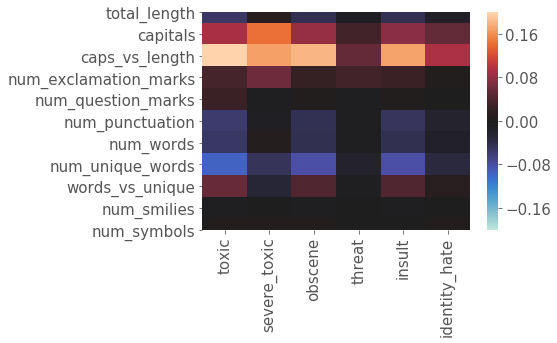

In [4]:
df = treino.copy()
df['total_length'] = df['comment_text'].apply(len)
df['capitals'] = df['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['total_length']),
                                axis=1)
df['num_exclamation_marks'] = df['comment_text'].apply(lambda comment: comment.count('!'))
df['num_question_marks'] = df['comment_text'].apply(lambda comment: comment.count('?'))
df['num_punctuation'] = df['comment_text'].apply(
    lambda comment: sum(comment.count(w) for w in '.,;:'))
df['num_symbols'] = df['comment_text'].apply(
    lambda comment: sum(comment.count(w) for w in '*&$%'))
df['num_words'] = df['comment_text'].apply(lambda comment: len(comment.split()))
df['num_unique_words'] = df['comment_text'].apply(
    lambda comment: len(set(w for w in comment.split())))
df['words_vs_unique'] = df['num_unique_words'] / df['num_words']
df['num_smilies'] = df['comment_text'].apply(
    lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))

features = ('total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks',
            'num_question_marks', 'num_punctuation', 'num_words', 'num_unique_words',
            'words_vs_unique', 'num_smilies', 'num_symbols')
columns = ('toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate')

rows = [{c:df[f].corr(df[c]) for c in columns} for f in features]
df_correlations = pd.DataFrame(rows, index=features)
df_correlations.style.background_gradient(cmap='seismic',axis=0)
ax = sns.heatmap(df_correlations, vmin=-0.2, vmax=0.2, center=0.0)

In [5]:
df[list(features)].describe()

,total_length,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_words,num_unique_words,words_vs_unique,num_smilies,num_symbols
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.00000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,394.073221,17.159628,0.051622,0.661624,0.44928,7.974131,67.273527,48.097323,0.855019,0.006680,0.117120
std,590.720282,96.528103,0.092837,25.899553,1.58990,12.770362,99.230702,54.436443,0.128176,0.089803,1.093046
min,6.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,0.000800,0.000000,0.000000
25%,96.000000,3.000000,0.020710,0.000000,0.00000,2.000000,17.000000,16.000000,0.779070,0.000000,0.000000
50%,205.000000,7.000000,0.031746,0.000000,0.00000,4.000000,36.000000,31.000000,0.875000,0.000000,0.000000
75%,435.000000,15.000000,0.048830,0.000000,1.00000,9.000000,75.000000,59.000000,0.956522,0.000000,0.000000
max,5000.000000,4960.000000,0.998189,4942.000000,209.00000,682.000000,1411.000000,816.000000,1.000000,8.000000,148.000000


## Patterns in different classes of labels for each new feature

In [6]:
for col in features:
    dict_df = {i : pd.concat([ytrain,df[col]],axis=1).groupby(i)[col] \
               .agg(['count','median','std']) for i in df.columns[1:6]}

    lengths = pd.DataFrame()
    for k,v in dict_df.items():
        lengths = pd.concat([lengths,v])

    lengths.index = pd.MultiIndex.from_product([dict_df.keys(), [0,1]])
    print(col)
    display(lengths.style.background_gradient(cmap='summer_r'))

total_length


capitals


caps_vs_length


num_exclamation_marks


num_question_marks


num_punctuation


num_words


num_unique_words


words_vs_unique


num_smilies


num_symbols


# Conclusions on text statistics
- It seems that a few of those features may bring information for classification algorithms.

## Tasks
- We will try to understand the frequency of co-occurence/strenght of association between different labels.
    - Considering we do have binary classes we will opt for 'Spearman rho', as a non-parametric measure for correlation;

(6.0, 0.0)

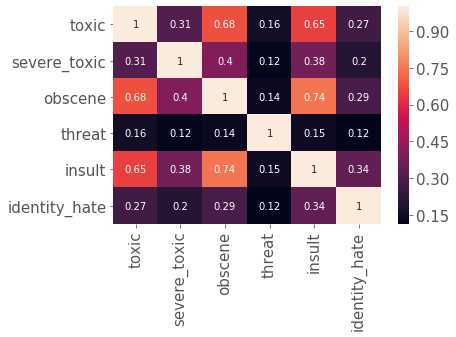

In [7]:
ax = sns.heatmap(ytrain.corr(method='spearman'),
                 xticklabels=ytrain.columns.values,
                 yticklabels=ytrain.columns.values,
                 annot=True)
bottom, top = ax.get_ylim()

ax.set_ylim(bottom + 0.5, top - 0.5) # quick-fix for matplolib 3.1.1 breaking seaborn

- It seems we do have stronger correlations between toxic-obscene, toxic-insult, obscene-insult.
- Interesting to observe that 'threat' does no present strong correlations with other labels.
    - Would that be the case that threateners usually focus their energy mainly on the threat?
    - Or a matter of definition of what threat is?
    - Or even the case that multi-labelling threating altogether with different labels would be difficult?

In [9]:
# what is this?
melt_df = pd.melt(df.reset_index(),
                  id_vars=['id','total_length'],var_name='toxicity_type',
                  value_vars=labels).set_index('id')
melt_df.sample(10)

,total_length,toxicity_type,value
id,,,
9937b33deec0cd71,984,threat,0
425ec3c32af1b68a,115,obscene,1
b5d6b6fc7946e139,97,threat,0
7c3d83f8dc4e8a1a,513,obscene,0
5f20e4fd0baf57e5,52,threat,0
2ecd27078c7a785a,279,insult,0
91fe74be1910f4c6,55,toxic,0
504e48a355476f6d,248,obscene,0
7c3af0b5dd2c9d82,52,insult,0


In [12]:
df[df.total_length >= df.total_length.max()]\
    ['comment_text'].to_frame().join(ytrain).sum(axis=1).sample(20)

id
c8f01ac90c4adc27    4
171ebb2b785f72bd    1
5e50cf56f160bda3    0
3b0e1b13380cdd7a    5
fb3a15d68a7e7ff2    1
ce2d7821188dd30f    5
70368dd072aebb42    1
44096c9bd35a200d    0
cbeeca0dd8d32c1a    4
8b31f2d7d6025482    2
199912b2d9973a21    4
300b0c81ea94e02d    0
c14532e93d456260    1
2be09ad5ce9a8a85    0
98e4e1f70d28631c    5
dd0bd64b02c550af    1
0b2055f13934a41e    3
96cac8dd8f971c7d    3
e6abb7915c7fd1f1    3
97e695cfd71944ed    4
dtype: int64

- straight away we can see that most of the max-size comments are labeled positively for at least one label and is not unusual to be in multiple ones.

